In [63]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import defaultdict

# Load Data

In [105]:
images = []
folder_path = "pokemon/"
for filename in os.listdir(folder_path):
    if filename.endswith(".png"):
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path).convert('RGB')
        img_array = np.array(img)
        if img_array.shape[0] != 42 or img_array.shape[1] != 56:
            continue
        images.append(img_array)
print(len(images))

1007


In [106]:
pixel_color_frequency = defaultdict(int)

for image in images:
    for row in range(image.shape[0]):  # Iterate over the rows
        for col in range(image.shape[1]):  # Iterate over the columns
            # Get the pixel color (as a tuple) at the current position
            pixel_color = tuple(image[row, col])  # (R, G, B)
            
            # Increment the count for this pixel color
            pixel_color_frequency[pixel_color] += 1

# Convert defaultdict back to a normal dictionary if needed
pixel_color_frequency = dict(pixel_color_frequency)

In [107]:
print(pixel_color_frequency)
#TODO generate a K means cluster of these 
# pixels in 3d space (with like 64 ks spread out randomly => convert images to this cluster and show a few of them

{(0, 0, 0): 1999818, (49, 49, 49): 27588, (197, 197, 197): 223, (255, 255, 255): 18408, (82, 82, 82): 13236, (172, 172, 172): 78, (106, 164, 255): 37, (65, 98, 172): 89, (123, 123, 115): 72, (74, 131, 205): 67, (213, 98, 65): 321, (82, 198, 82): 15, (82, 200, 82): 4, (8, 0, 8): 98, (74, 148, 82): 7, (90, 189, 90): 1, (49, 94, 49): 1, (66, 66, 66): 13272, (47, 77, 47): 2, (66, 115, 66): 6, (57, 115, 57): 4, (0, 16, 0): 13, (86, 57, 54): 1, (66, 82, 66): 9, (247, 118, 159): 12, (255, 111, 159): 1, (170, 74, 106): 1, (173, 99, 109): 1, (247, 115, 159): 23, (189, 65, 109): 3, (197, 100, 133): 9, (198, 99, 134): 17, (189, 66, 109): 2, (214, 107, 142): 3, (213, 123, 131): 21, (172, 90, 98): 16, (255, 180, 164): 137, (213, 156, 139): 23, (90, 172, 115): 28, (139, 205, 156): 77, (246, 230, 115): 12, (230, 205, 98): 12, (180, 148, 65): 1, (82, 131, 82): 14, (246, 230, 172): 30, (123, 156, 74): 78, (156, 205, 74): 97, (213, 197, 106): 27, (82, 115, 65): 7, (189, 82, 123): 3, (0, 0, 8): 546, (255

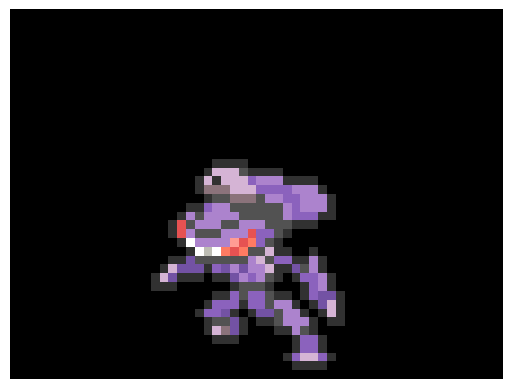

(1007, 42, 56, 3)


In [109]:
plt.imshow(images[573])
plt.axis('off')
plt.show()

normalized_images = np.array([(image - 127.5)/127.5 for image in images])
print(normalized_images.shape)

# Build Model

In [110]:
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(128, activation="relu")
        self.dense_2 = tf.keras.layers.Dense(42 * 56 * 64, activation="relu")
        self.reshape = tf.keras.layers.Reshape((42, 56, 64))
        self.convTrans = tf.keras.layers.Conv2DTranspose(64, (4, 4), strides=(1, 1), padding='same')
        self.conv = tf.keras.layers.Conv2D(3, (3, 3), activation='tanh', padding='same')

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.reshape(x)
        x = self.convTrans(x)
        return self.conv(x)

class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv_1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation="relu")
        self.conv_2 = tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation="relu")
        self.conv_3 = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation="relu")
        self.flatten = tf.keras.layers.Flatten()
        self.out = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.flatten(x)
        return self.out(x)


In [111]:
class GAN(tf.keras.Model):
    # define the models
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
    
    # Define the compiler
    def compile(self, disc_optimizer, gen_optimizer, loss_fn, generator_loss, discriminator_loss):
        super(GAN, self).compile()
        self.disc_optimizer = disc_optimizer
        self.gen_optimizer = gen_optimizer
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss
        self.loss_fn = loss_fn

        
    # @tf.function: The below function is completely Tensor Code
    # Good for optimization
    @tf.function
    # Modify Train step for GAN
    def train_step(self, images):
        batch_size = tf.shape(images)[0]
        noise = tf.random.normal([batch_size, self.latent_dim])

        # Define the loss function
        with tf.GradientTape(persistent=True) as tape:
            generated_images = self.generator(noise)
            real_output = self.discriminator(images)
            fake_output = self.discriminator(generated_images)
            
            gen_loss = self.generator_loss(self.loss_fn, fake_output)
            disc_loss = self.discriminator_loss(self.loss_fn, real_output, fake_output)

        # Calculate Gradient
        grad_disc = tape.gradient(disc_loss, self.discriminator.trainable_variables)
        grad_gen = tape.gradient(gen_loss, self.generator.trainable_variables)

        # Optimization Step: Update Weights & Learning Rate
        self.disc_optimizer.apply_gradients(zip(grad_disc, self.discriminator.trainable_variables))
        self.gen_optimizer.apply_gradients(zip(grad_gen, self.generator.trainable_variables))
        
        return {"Gen Loss ": gen_loss,"Disc Loss" : disc_loss}

In [112]:
latent_dim = 50
epochs = 25
batch_size = 64

gen_optimizer = tf.keras.optimizers.Adam(0.0001)
disc_optimizer = tf.keras.optimizers.Adam(0.0001)

def discriminator_loss(loss_object, real_output, fake_output):
    real_loss = loss_object(tf.ones_like(real_output), real_output)
    fake_loss = loss_object(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# loss object: Binary Crossentropy Loss
# discriminator_probability: Result from Discriminator 0 = Fake 1 = Real
def generator_loss(loss_object, discriminator_probability):
    return loss_object(tf.ones_like(discriminator_probability), discriminator_probability)

disc = Discriminator()
gen = Generator()

gan = GAN(discriminator=disc, generator=gen, latent_dim=latent_dim)
gan.compile(
    disc_optimizer=disc_optimizer,
    gen_optimizer=gen_optimizer,
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    generator_loss = generator_loss,
    discriminator_loss = discriminator_loss
)

gan.fit(
    normalized_images, 
    epochs=epochs
)

Epoch 1/25
 9/32 ━━━━━━━━━━━━━━━━━━━━ 16s 731ms/step - Disc Loss: 1.2661 - Gen Loss : 0.5853

KeyboardInterrupt: 

# Generate

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
(42, 56, 3)


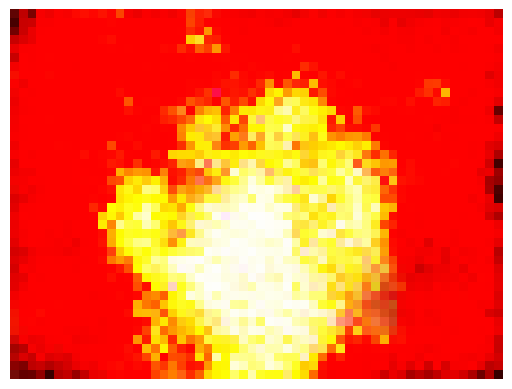

In [76]:
noise = tf.random.normal([1, latent_dim])
image = gen.predict(noise)[0]
de_normalized_img = (image + 1)/2
print(de_normalized_img.shape)
plt.imshow(de_normalized_img)
plt.axis('off')
plt.show()